# Data Mining Project - Predict Covid-19 Confirmed Cases Outcome

The goal of this notebook is to compare various models for classification, so as to come up with the best model to predict the outcome of the disease (cured / died) caused by Sars-Cov-2.

In the previous notebook the data from the site of the public health department of the "Estado do Espirito Santo" in Brazil were cleaned, translated from Portuguese to English and kept only the features useful for the survey (chosen on the basis of scientific studies)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from collections import Counter
from joblib import dump, load

Import PreProcessing utils

In [2]:
from sklearn.model_selection import cross_val_predict, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

Import SkLearn libraries for ML models

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

Import XGBoost Classifier

In [4]:
from xgboost import XGBClassifier

Import SMOTE oversampling-kit

In [5]:
from imblearn.over_sampling import SMOTE

Import SkLearn libraries for metrics

In [6]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score, make_scorer

Import Data from *brazilian_data_en.csv* and do some cleaning actions

In [7]:
df = pd.read_csv("cleaned_data/brazilian_data_en.csv")
pd.set_option('display.max_columns', None)

In [8]:
df = df.loc[df["Pregnancy"] != "Gestational age ignored"]
df = df.drop(['Diagnosis Date','Closing Date',"RT_PCR Result","QuickTestResult"],axis=1)

## Data Encoding

Split the sample in *Closed Cases* and *Open Cases*. At the moment, we focus only on the closed cases for our model evaluations

In [9]:
df_open = df.loc[(df['Status Notification'] == "Open")
                 & (df['Evolution'] == "Unknown")
                 & (df['Classification'] != "Discarded")].reset_index().drop(['index', 'Classification', 'Evolution',
                                                                      'Confirmation Criteria',
                                                                             'Status Notification',
                                                                             'Position'],axis=1)
df_open.to_csv('cleaned_data/braz_open_cases.csv',index=False)
print("Open Cases: " + str(df_open.shape[0]))

Open Cases: 196751


In [10]:
df_closed = df.loc[(df['Status Notification'] == "Closed")
                   & (df['Evolution'] != "Unknown")
                   & (df['Classification'] != "Discarded")].reset_index().drop(['index', 'Classification',
                                                                                'Confirmation Criteria',
                                                                                'Status Notification',
                                                                               'Position'],axis=1)
df_closed.to_csv('cleaned_data/braz_closed.csv',index=False)
print("Closed Cases: " + str(df_closed.shape[0]))

Closed Cases: 600242


We have to apply:
- "OneHotEncoder" to columns with non-ordinal features [pandas.get_dummies()]
- "LabelEncoder" to columns with ordinal features (Age Range, Education Level, Pregnancy) [manual dictionary]
- "NoEncoder" to columns "Age"

In [11]:
def encoding_dataset(data):
    dict_pregnancy = {
        "No":0,
        "Unknown":1,
        "1st trimester": 2,
        "2nd trimester": 3,
        "3rd trimester": 4
    }
    dict_education = {
        'Unknown': 0,
        'Illliterate': 1,
        'Incomplete 1st to 4th grade of elementary school': 2,
        '4th grade of elementary school': 3,
        'Incomplete 5th to 8th grade of elementary school': 4,
        'Complete elementary school': 5,
        'Incomplete high school': 6,
        'Complete high school': 7,
        'Incomplete higher education': 8,
        'Complete higher education': 9
    }
    dict_age_range = {
        '0-4': 0,
        '5-9': 1,
        '10-19': 2,
        '20-29': 3,
        '30-39': 4,
        '40-49': 5,
        '50-59': 6, 
        '60-69': 7,
        '70-79': 8,
        '80-89': 9,
        '90-100': 10
    }
    dict_gender = {
        "M":1,
        "F":0
    }
    dict_evolution = {
        "Cure":1,
        "Death":0
    }
    
    data = data.replace({"Evolution":dict_evolution, "Age range":dict_age_range,
                         "Education Level":dict_education, "Pregnancy":dict_pregnancy, "Gender":dict_gender})
    #Add Useful column to the dataset: sum of comorbitites, sum of symptomps
    col_sym = list(data.iloc[:,6:13].columns.values)
    col_com = list(data.iloc[:,13:19].columns.values)
    
    data['sum_comorb'] = (data[col_com] == 'Yes').sum(axis=1)
    data['sum_sym'] = (data[col_sym] == 'Yes').sum(axis=1)
    
    cat_cols = list(data.columns.values)
    cat_cols.remove("Age range")
    cat_cols.remove("Age")
    cat_cols.remove("Education Level")
    cat_cols.remove("Pregnancy")
    cat_cols.remove("Evolution")
    cat_cols.remove("Gender")
    cat_cols.remove("sum_comorb")
    cat_cols.remove("sum_sym")
                
    
    #Encoding with "get_dummies()" tool in pandas
    data2 = pd.get_dummies(data,columns=cat_cols)
    data2["Age range"] = data["Age range"]
    data2["Education Level"] = data["Education Level"]
    data2["Pregnancy"] = data["Pregnancy"]
    data2['Gender'] = data['Gender']
    data2['sum_comorb'] = data['sum_comorb']
    data2['sum_sym'] = data['sum_sym']
    
    #Apply Standard Scale on the columns below
    col_names = ['Education Level', 'Pregnancy', 'Age range', 'Age']
    features = data2[col_names]
    ct = ColumnTransformer([
        ('somename', StandardScaler(), col_names)
    ], remainder='passthrough')
    data2[col_names] = ct.fit_transform(features)
    
    return data2

In [12]:
def decoding_dataset(df):
    dict_pregnancy = {
        "No":0,
        "Unknown":1,
        "1st trimester": 2,
        "2nd trimester": 3,
        "3rd trimester": 4
    }
    dict_education = {
        'Unknown': 0,
        'Illliterate': 1,
        'Incomplete 1st to 4th grade of elementary school': 2,
        '4th grade of elementary school': 3,
        'Incomplete 5th to 8th grade of elementary school': 4,
        'Complete elementary school': 5,
        'Incomplete high school': 6,
        'Complete high school': 7,
        'Incomplete higher education': 8,
        'Complete higher education': 9
    }
    dict_age_range = {
        '0-4': 0,
        '5-9': 1,
        '10-19': 2,
        '20-29': 3,
        '30-39': 4,
        '40-49': 5,
        '50-59': 6, 
        '60-69': 7,
        '70-79': 8,
        '80-89': 9,
        '90-100': 10
    }
    dict_gender = {
        "M":1,
        "F":0
    }
    dict_evolution = {
        "Cure":1,
        "Death":0
    }

    def inv_map(my_map):
        return {v: k for k, v in my_map.items()}

    temp = df_closed.replace({"Evolution":dict_evolution, "Age range":dict_age_range,
                         "Education Level":dict_education, "Pregnancy":dict_pregnancy, "Gender":dict_gender})

    col_names = ['Education Level', 'Pregnancy', 'Age range', 'Age']
    features = temp[col_names]
    ct = ColumnTransformer([
        ('scaler', StandardScaler(), col_names)
    ], remainder='passthrough')
    ct.fit(features)

    df[col_names] = ct.named_transformers_['scaler'].inverse_transform(df[col_names])
    df[col_names] = df[col_names].round(0).astype(int)
    df_ret = df.replace({"Evolution":inv_map(dict_evolution), "Age range":inv_map(dict_age_range),
                                "Education Level":inv_map(dict_education), "Pregnancy":inv_map(dict_pregnancy),
                                 "Gender":inv_map(dict_gender)})
    return df_ret

In [13]:
df_closed_enc = encoding_dataset(df_closed)

In [14]:
df_closed_enc

,Evolution,Age range,Age,Gender,Education Level,Pregnancy,sum_comorb,sum_sym,Fever_No,Fever_Unknown,Fever_Yes,Respiratory Difficulty_No,Respiratory Difficulty_Unknown,Respiratory Difficulty_Yes,Cough_No,Cough_Unknown,Cough_Yes,Coryza_No,Coryza_Unknown,Coryza_Yes,Sore throat_No,Sore throat_Unknown,Sore throat_Yes,Diarrhoea_No,Diarrhoea_Unknown,Diarrhoea_Yes,CEPHALGIA_No,CEPHALGIA_Unknown,CEPHALGIA_Yes,ComorbidityLung_No,ComorbidityLung_Unknown,ComorbidityLung_Yes,ComorbidityCardio_No,ComorbidityCardio_Unknown,ComorbidityCardio_Yes,Renal comorbidity_No,Renal comorbidity_Unknown,Renal comorbidity_Yes,comorbidity diabetes_No,comorbidity diabetes_Unknown,comorbidity diabetes_Yes,Comorbidity Smoking_No,Comorbidity Smoking_Unknown,Comorbidity Smoking_Yes,comorbidity obesity_No,comorbidity obesity_Unknown,comorbidity obesity_Yes,was hospitalized_No,was hospitalized_Unknown,was hospitalized_Yes,International trip_No,International trip_Unknown,International trip_Yes,professional health_No,professional health_Unknown,professional health_Yes,has a disability_No,has a disability_Unknown,has a disability_Yes,Homeless_No,Homeless_Unknown,Homeless_Yes
0,1,1.358003,1.361740,1,0.352592,-0.079411,2,4,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0
1,1,1.912779,1.704290,1,-0.506148,-0.079411,0,3,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0
2,1,-1.970653,-1.778306,0,-1.078641,-0.079411,0,2,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
3,1,-0.306325,-0.122645,1,1.211332,-0.079411,0,2,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0
4,1,-0.306325,-0.122645,1,1.211332,-0.079411,0,2,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600237,1,-0.861101,-0.921929,0,-1.078641,-0.079411,0,3,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0
600238,1,0.248451,0.048630,1,-1.078641,-0.079411,0,3,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0
600239,1,-0.306325,-0.522287,1,-1.078641,-0.079411,0,3,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0
600240,1,0.248451,0.105722,1,-1.078641,-0.079411,2,4,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0


## Models and Metrics

### Models
- Logistic Regression (LR)
- Linear Discriminant Analysis (LDA)
- Naive Bayes (NB)
- K-Nearest Neighbors (KNN) [SO MUCH TIME]
- Decision Trees (DT)
- XGBOOST (XGB)
- Support Vector Machine (SVM)

### Metrics
- accuracy
- Receiver Operating Characteristic curve and area under the curve (ROC_AUC)
- precision
- recall
- Precision-Recall curve and area under the curve
- F1-score
- confusion matrix
- r squared
- mean absolute error

In [15]:
cure_closed = df_closed_enc.loc[df_closed_enc["Evolution"] == 1].shape[0]
death_closed = df_closed_enc.loc[df_closed_enc["Evolution"] == 0].shape[0]
print("Cure closed cases before resampling are: " + "{:.2f}".format(100*cure_closed/(cure_closed + death_closed)) +
      "%, " + str(cure_closed) + " people over " + str(cure_closed+death_closed))
print("Death closed cases before resampling are: " + "{:.2f}".format(100*death_closed/(cure_closed + death_closed)) +
      "%, " + str(death_closed) + " people over " + str(cure_closed+death_closed))

Cure closed cases before resampling are: 97.85%, 587354 people over 600242
Death closed cases before resampling are: 2.15%, 12888 people over 600242


In [16]:
X_id = df_closed_enc.drop('Evolution',axis=1)
y_id = df_closed_enc.Evolution
print("X shape:", X_id.shape, "|", "y shape:", y_id.shape)

X shape: (600242, 61) | y shape: (600242,)


In [17]:
sm = SMOTE(sampling_strategy=0.5, random_state=42)
X, y = sm.fit_resample(X_id, y_id)
print('Resampled dataset shape %s' % Counter(y))

Resampled dataset shape Counter({1: 587354, 0: 293677})


In [18]:
scoring_dict = {
        "r2": "r2",
        "mae": "neg_mean_absolute_error",
        "accuracy": "accuracy",
        "precision": "precision",
        "recall": "recall",
        "f1": "f1",
        "kappa": make_scorer(cohen_kappa_score),
        "roc_auc": "roc_auc",
        "pr_auc": "average_precision"
    }

In [19]:
models = [
    LogisticRegression(solver='sag', max_iter=900, n_jobs=4),
    #KNeighborsClassifier(n_neighbors=5, n_jobs=3),
    LinearDiscriminantAnalysis(),
    GaussianNB(),
    DecisionTreeClassifier(),
    #XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    #SVC(gamma="auto"),
    RandomForestClassifier(n_estimators=100, n_jobs=4)
]

In [20]:
def evaluate_model(model,X,y):
    scores = cross_validate(model, X, y, scoring=scoring_dict, cv=10, return_train_score=True, verbose=2)
    predict = cross_val_predict(model, X, y, cv=10)
    
    return scores, predict, confusion_matrix(y,predict)

### Experiment Function

In [21]:
def get_models_names(models):
    ret = []
    for elem in models:
        ret.append(str(elem).split("(")[0])
    return ret

In [22]:
result_key = get_models_names(models)

In [23]:
result_values = []
for model_elem in tqdm(models):
    print("Model fit: " + str(model_elem).split("(")[0])
    ret_scores, ret_predict, ret_cm = evaluate_model(model_elem,X,y)
    result_values.append((ret_scores, ret_predict, ret_cm))

  0%|                                                     | 0/5 [00:00<?, ?it/s]

Model fit: LogisticRegression


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 3.0min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min remaining:    0.0s


[CV] END .................................................... total time= 6.2min
[CV] END .................................................... total time= 3.1min
[CV] END .................................................... total time= 3.1min
[CV] END .................................................... total time= 3.1min
[CV] END .................................................... total time= 3.2min
[CV] END .................................................... total time= 3.1min
[CV] END .................................................... total time= 3.1min
[CV] END .................................................... total time= 3.2min
[CV] END .................................................... total time= 3.3min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 34.7min finished
 20%|███████▊                               | 1/5 [1:06:02<4:24:10, 3962.59s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model fit: LinearDiscriminantAnalysis
[CV] END .................................................... total time=   4.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s


[CV] END .................................................... total time=   4.9s
[CV] END .................................................... total time=   5.2s
[CV] END .................................................... total time=   5.1s
[CV] END .................................................... total time=   5.1s
[CV] END .................................................... total time=   5.1s
[CV] END .................................................... total time=   4.9s
[CV] END .................................................... total time=   4.9s
[CV] END .................................................... total time=   5.2s
[CV] END .................................................... total time=   5.2s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.0min finished
 40%|███████████████▌                       | 2/5 [1:07:53<1:24:50, 1696.92s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model fit: GaussianNB
[CV] END .................................................... total time=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.6s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.4s finished
 60%|█████████████████████████▏                | 3/5 [1:08:20<31:08, 934.25s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model fit: DecisionTreeClassifier
[CV] END .................................................... total time=   4.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


[CV] END .................................................... total time=   4.9s
[CV] END .................................................... total time=   4.9s
[CV] END .................................................... total time=   4.9s
[CV] END .................................................... total time=   4.9s
[CV] END .................................................... total time=   4.9s
[CV] END .................................................... total time=   5.0s
[CV] END .................................................... total time=   5.1s
[CV] END .................................................... total time=   5.0s
[CV] END .................................................... total time=   4.6s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   59.0s finished
 80%|█████████████████████████████████▌        | 4/5 [1:10:06<10:07, 607.48s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model fit: RandomForestClassifier
[CV] END .................................................... total time=  25.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.6s remaining:    0.0s


[CV] END .................................................... total time=  29.4s
[CV] END .................................................... total time=  29.0s
[CV] END .................................................... total time=  28.5s
[CV] END .................................................... total time=  26.6s
[CV] END .................................................... total time=  28.1s
[CV] END .................................................... total time=  29.0s
[CV] END .................................................... total time=  26.2s
[CV] END .................................................... total time=  26.2s
[CV] END .................................................... total time=  27.4s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  6.1min finished
100%|██████████████████████████████████████████| 5/5 [1:20:54<00:00, 970.96s/it]


### Aggregated values dict || Transform dict to DF

In [24]:
result_dict = dict(zip(result_key,result_values))

In [25]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [26]:
def merge_predict_test(X_te,y_te,pred):
    y_df = pd.concat([y_te,X_te], axis=1).reset_index().drop(['index'],axis=1).replace({"Evolution":{0:"Death",1:"Cure"}})
    pred_df = pd.DataFrame(pred, columns=["Pred_Evolution"])
    temp = pd.concat([pred_df.replace({0:"Death",1:"Cure"}),y_df],axis=1)
    return pd.concat([temp.iloc[:,:9],undummify(temp.iloc[:,9:])],axis=1)

In [27]:
def aggregate_values(d):
    aggr_dict = {}
    for key in d:
        aggr_dict[key] = {
            "mean": np.mean(d[key]),
            "std": np.std(d[key]),
            "min": np.min(d[key]),
            "max": np.max(d[key])
        }
    return aggr_dict

def show_aggr(d,model):
    return d[model][0].describe().iloc[[1,2,3,7]]

In [28]:
def dict_to_df(x):
    index_df_model = ["K1","K2","K3","K4","K5","K6","K7","K8","K9","K10"]
    res = pd.DataFrame.from_dict(x)
    res.index = index_df_model
    return res

In [29]:
for key in result_dict:
    result_dict[key] = list(result_dict[key])
    result_dict[key][0] = dict_to_df(result_dict[key][0])
    result_dict[key][1] = merge_predict_test(X,y,result_dict[key][1])
    result_dict[key].append(aggregate_values(result_dict[key][0]))

### Display Dataframe functions

In [30]:
def get_total_values(d,aggr):
    ret = {}
    for key in d:
        ret[key] = {}
    for key in d:
        for k in d[key][3]:
            ret[key].update({
                k: d[key][3][k][aggr]
            })
    return ret

def show_total_values(d, type_plot):
    if type_plot == "train":
        new_dict = copy.deepcopy(d)
        for k in new_dict:
            for key in list(new_dict[k].keys()):
                if "test" in key:
                    del new_dict[k][key]
        return pd.DataFrame.from_dict(new_dict).T
    
    if type_plot == "test":
        new_dict = copy.deepcopy(d)
        for k in new_dict:
            for key in list(new_dict[k].keys()):
                if "train" in key:
                    del new_dict[k][key]
        return pd.DataFrame.from_dict(new_dict).T
    
    else:
        return pd.DataFrame.from_dict(d).T

In [31]:
def plot_cm(cm, title):
    ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    ax.set_title(title + ': Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Death','Cure'])
    ax.yaxis.set_ticklabels(['Death','Cure'])
    
    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [32]:
def display_bad_predictions(data):
    return data.loc[(data["Pred_Evolution"] != data['Evolution'])]

## Plot Data for every Model

Data Structure of **result_dict** is:
- *result_dict[model_name][0]* : DataFrame for K-Fold-CrossValidation scores
- *result_dict[model_name][1]* : DataFrame for Prediction vs Real evaluation
- *result_dict[model_name][2]* : Confusion matrix (use plot_cm function to visualize it)
- *result_dict[model_name][3]* : Dictionary with Aggregated Values for selected model

Some functions for visualization:
- *plot_cm(confusion_matrix,model_name)* : Plot Confusion Matrix
- *show_aggr(main_dictionary,model_name)* : Display Aggregated values for selected model

In [33]:
result_dict.keys()

dict_keys(['LogisticRegression', 'LinearDiscriminantAnalysis', 'GaussianNB', 'DecisionTreeClassifier', 'RandomForestClassifier'])

### Logistic Regression

10-Fold-CrossValidation Results


,fit_time,score_time,test_r2,train_r2,test_mae,train_mae,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_kappa,train_kappa,test_roc_auc,train_roc_auc,test_pr_auc,train_pr_auc
K1,180.787356,0.141337,0.572596,0.713126,-0.094979,-0.063750,0.905021,0.936250,0.898973,0.940158,0.966103,0.965852,0.931330,0.952832,0.778010,0.854576,0.961611,0.982015,0.976676,0.990458
K2,369.281039,0.145425,0.724337,0.697837,-0.061258,-0.067147,0.938742,0.932853,0.941541,0.936655,0.968231,0.964507,0.954699,0.950377,0.860186,0.846639,0.983124,0.979863,0.991163,0.989084
K3,185.720663,0.149084,0.709831,0.700596,-0.064481,-0.066534,0.935519,0.933466,0.941030,0.937198,0.963668,0.964854,0.952214,0.950825,0.853149,0.848056,0.981015,0.980140,0.989747,0.989273
K4,188.118324,0.148373,0.710035,0.700266,-0.064436,-0.066608,0.935564,0.933392,0.941636,0.937263,0.963038,0.964659,0.952217,0.950764,0.853351,0.847910,0.981124,0.980137,0.989751,0.989286
K5,186.890750,0.164371,0.714126,0.699500,-0.063528,-0.066778,0.936472,0.933222,0.942301,0.937118,0.963718,0.964557,0.952889,0.950639,0.855420,0.847517,0.981717,0.980062,0.990241,0.989227
K6,190.917205,0.136826,0.713258,0.699693,-0.063721,-0.066735,0.936279,0.933265,0.940188,0.937242,0.965864,0.964479,0.952853,0.950666,0.854644,0.847632,0.981539,0.980059,0.990131,0.989226
K7,188.815355,0.135476,0.730266,0.697491,-0.059941,-0.067224,0.940059,0.932776,0.940618,0.936687,0.971414,0.964347,0.955768,0.950315,0.862889,0.846479,0.984061,0.979782,0.991499,0.989078
K8,187.125617,0.133075,0.727559,0.697973,-0.060543,-0.067117,0.939457,0.932883,0.941163,0.936674,0.969814,0.964534,0.955273,0.950400,0.861674,0.846707,0.983673,0.979817,0.991388,0.989081
K9,192.098113,0.137635,0.697322,0.701764,-0.067262,-0.066275,0.932738,0.933725,0.941436,0.937434,0.958747,0.964994,0.950013,0.951014,0.847257,0.848657,0.980349,0.980199,0.989649,0.989290
K10,196.283881,0.142668,0.295760,0.703608,-0.156499,-0.065865,0.843501,0.934135,0.932707,0.937617,0.824755,0.965436,0.875416,0.951324,0.667142,0.849573,0.896677,0.980319,0.955361,0.989340


----------------------------------------
Aggregated values


,fit_time,score_time,test_r2,train_r2,test_mae,train_mae,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_kappa,train_kappa,test_roc_auc,train_roc_auc,test_pr_auc,train_pr_auc
mean,206.603830,0.143427,0.659509,0.701185,-0.075665,-0.066403,0.924335,0.933597,0.936159,0.937405,0.951535,0.964822,0.943267,0.950916,0.829372,0.848375,0.971489,0.980239,0.985561,0.989334
std,57.305816,0.009138,0.135849,0.004597,0.030189,0.001022,0.030189,0.001022,0.013350,0.001023,0.044695,0.000482,0.024872,0.000741,0.062228,0.002380,0.027088,0.000648,0.011480,0.000406
min,180.787356,0.133075,0.295760,0.697491,-0.156499,-0.067224,0.843501,0.932776,0.898973,0.936655,0.824755,0.964347,0.875416,0.950315,0.667142,0.846479,0.896677,0.979782,0.955361,0.989078
max,369.281039,0.164371,0.730266,0.713126,-0.059941,-0.063750,0.940059,0.936250,0.942301,0.940158,0.971414,0.965852,0.955768,0.952832,0.862889,0.854576,0.984061,0.982015,0.991499,0.990458


----------------------------------------
Confusion Matrix


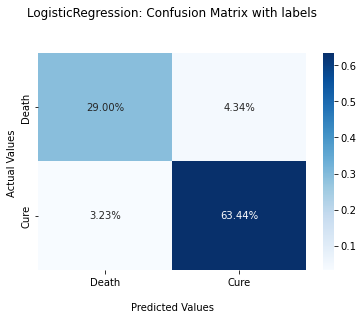

None

----------------------------------------
Bad Predictions: 66663 over 881031--> 7.57%


,Pred_Evolution,Evolution,Age range,Age,Gender,Education Level,Pregnancy,sum_comorb,sum_sym,Fever,Respiratory Difficulty,Cough,Coryza,Sore throat,Diarrhoea,CEPHALGIA,ComorbidityLung,ComorbidityCardio,Renal comorbidity,comorbidity diabetes,Comorbidity Smoking,comorbidity obesity,was hospitalized,International trip,professional health,has a disability,Homeless
11,Cure,Death,0.803227,0.676639,1,0.925085,-0.079411,0,0,No,No,No,No,No,No,No,No,No,No,No,No,No,Unknown,Unknown,No,No,No
43,Cure,Death,-2.525429,-2.063764,0,-1.078641,-0.079411,0,1,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
52,Cure,Death,1.912779,1.875566,0,-0.792395,-0.079411,1,1,Yes,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No
135,Cure,Death,0.803227,1.076281,1,-1.078641,4.422439,3,2,No,Yes,Yes,No,No,No,No,Yes,Yes,No,No,No,Yes,Unknown,Unknown,No,No,No
169,Cure,Death,-0.861101,-0.864838,1,-0.792395,-0.079411,0,0,No,No,No,No,No,No,No,No,No,No,No,No,No,Unknown,Unknown,No,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880993,Cure,Death,0.763771,0.705309,1,-0.465433,-0.079411,0,0,No,No,No,No,No,No,No,No,No,No,No,No,No,Unknown,Unknown,No,No,No
881008,Cure,Death,0.856927,0.783467,0,0.149468,-0.079411,0,4,Yes,Yes,Yes,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No
881009,Cure,Death,1.891672,2.134959,0,-1.045970,-0.079411,0,4,Yes,No,Yes,Yes,No,No,Yes,No,No,No,No,No,No,Unknown,Unknown,No,No,No
881010,Cure,Death,1.358003,1.240155,0,-1.078641,-0.079411,0,1,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,Unknown,No,No


In [34]:
print("10-Fold-CrossValidation Results")
display(result_dict['LogisticRegression'][0])
print("-"*40)

print("Aggregated values")
display(show_aggr(result_dict, 'LogisticRegression'))
print("-"*40)

print("Confusion Matrix")
display(plot_cm(result_dict['LogisticRegression'][2],"LogisticRegression"))
print("-"*40)

n_bad_pred_logreg = display_bad_predictions(result_dict['LogisticRegression'][1]).shape[0]
print("Bad Predictions: " + str(n_bad_pred_logreg) + " over " + str(X.shape[0]) + "--> " + "{:.2f}%".format(100*n_bad_pred_logreg/X.shape[0]))
display_bad_predictions(result_dict['LogisticRegression'][1])

### Linear Discriminant Analysis

10-Fold-CrossValidation Results


,fit_time,score_time,test_r2,train_r2,test_mae,train_mae,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_kappa,train_kappa,test_roc_auc,train_roc_auc,test_pr_auc,train_pr_auc
K1,4.717790,0.136293,0.531633,0.657571,-0.104082,-0.076095,0.895918,0.923905,0.877054,0.912944,0.981459,0.979235,0.926324,0.944928,0.750996,0.822335,0.965181,0.979284,0.979447,0.989202
K2,4.728422,0.128438,0.666006,0.645104,-0.074220,-0.078866,0.925780,0.921134,0.913953,0.910067,0.981034,0.978385,0.946306,0.942990,0.826641,0.815632,0.981133,0.977240,0.990341,0.987887
K3,5.048507,0.139589,0.656302,0.648038,-0.076377,-0.078214,0.923623,0.921786,0.913956,0.910959,0.977458,0.978302,0.944641,0.943430,0.821966,0.817265,0.978471,0.977570,0.988681,0.988109
K4,4.954526,0.158465,0.665189,0.647652,-0.074402,-0.078300,0.925598,0.921700,0.915712,0.911082,0.978463,0.977999,0.946048,0.943355,0.826655,0.817110,0.978939,0.977545,0.988791,0.988113
K5,4.961930,0.149713,0.667902,0.646896,-0.073800,-0.078467,0.926200,0.921533,0.916166,0.910867,0.978871,0.978001,0.946481,0.943241,0.828067,0.816693,0.979495,0.977455,0.989249,0.988043
K6,4.919093,0.148448,0.668668,0.646800,-0.073630,-0.078489,0.926370,0.921511,0.914917,0.911001,0.980761,0.977791,0.946695,0.943215,0.828150,0.816680,0.979435,0.977430,0.989172,0.988034
K7,4.795053,0.136862,0.678475,0.644479,-0.071450,-0.079005,0.928550,0.920995,0.915202,0.910300,0.983996,0.977850,0.948353,0.942866,0.832960,0.815390,0.981958,0.977143,0.990533,0.987876
K8,4.801896,0.132283,0.669587,0.644797,-0.073425,-0.078934,0.926575,0.921066,0.914415,0.910125,0.981749,0.978196,0.946886,0.942934,0.828479,0.815499,0.980962,0.977183,0.990133,0.987885
K9,5.100709,0.148703,0.644100,0.649910,-0.079089,-0.077798,0.920911,0.922202,0.914182,0.911276,0.972674,0.978580,0.942522,0.943730,0.816169,0.818243,0.976357,0.977620,0.987757,0.988111
K10,5.100064,0.139486,0.256840,0.652969,-0.165148,-0.077118,0.834852,0.922882,0.903023,0.911917,0.842785,0.978873,0.871865,0.944210,0.640413,0.819872,0.904907,0.977916,0.957066,0.988250


----------------------------------------
Aggregated values


,fit_time,score_time,test_r2,train_r2,test_mae,train_mae,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_kappa,train_kappa,test_roc_auc,train_roc_auc,test_pr_auc,train_pr_auc
mean,4.912799,0.141828,0.610470,0.648422,-0.086562,-0.078129,0.913438,0.921871,0.909858,0.911054,0.965925,0.978321,0.936612,0.943490,0.800050,0.817472,0.970684,0.977638,0.985117,0.988151
std,0.145746,0.009227,0.131396,0.004110,0.029199,0.000913,0.029199,0.000913,0.012129,0.000870,0.043376,0.000464,0.023624,0.000646,0.061020,0.002187,0.023603,0.000622,0.010368,0.000389
min,4.717790,0.128438,0.256840,0.644479,-0.165148,-0.079005,0.834852,0.920995,0.877054,0.910067,0.842785,0.977791,0.871865,0.942866,0.640413,0.815390,0.904907,0.977143,0.957066,0.987876
max,5.100709,0.158465,0.678475,0.657571,-0.071450,-0.076095,0.928550,0.923905,0.916166,0.912944,0.983996,0.979235,0.948353,0.944928,0.832960,0.822335,0.981958,0.979284,0.990533,0.989202


----------------------------------------
Confusion Matrix


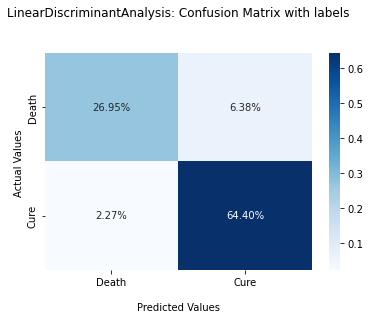

None

----------------------------------------
Bad Predictions: 76264 over 881031--> 8.66%


,Pred_Evolution,Evolution,Age range,Age,Gender,Education Level,Pregnancy,sum_comorb,sum_sym,Fever,Respiratory Difficulty,Cough,Coryza,Sore throat,Diarrhoea,CEPHALGIA,ComorbidityLung,ComorbidityCardio,Renal comorbidity,comorbidity diabetes,Comorbidity Smoking,comorbidity obesity,was hospitalized,International trip,professional health,has a disability,Homeless
11,Cure,Death,0.803227,0.676639,1,0.925085,-0.079411,0,0,No,No,No,No,No,No,No,No,No,No,No,No,No,Unknown,Unknown,No,No,No
43,Cure,Death,-2.525429,-2.063764,0,-1.078641,-0.079411,0,1,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
52,Cure,Death,1.912779,1.875566,0,-0.792395,-0.079411,1,1,Yes,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No
135,Cure,Death,0.803227,1.076281,1,-1.078641,4.422439,3,2,No,Yes,Yes,No,No,No,No,Yes,Yes,No,No,No,Yes,Unknown,Unknown,No,No,No
169,Cure,Death,-0.861101,-0.864838,1,-0.792395,-0.079411,0,0,No,No,No,No,No,No,No,No,No,No,No,No,No,Unknown,Unknown,No,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881009,Cure,Death,1.891672,2.134959,0,-1.045970,-0.079411,0,4,Yes,No,Yes,Yes,No,No,Yes,No,No,No,No,No,No,Unknown,Unknown,No,No,No
881010,Cure,Death,1.358003,1.240155,0,-1.078641,-0.079411,0,1,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,Unknown,No,No
881011,Cure,Death,1.200606,1.052785,1,0.679444,-0.079411,0,5,Yes,Yes,Yes,Yes,No,No,Yes,No,No,No,No,No,No,Unknown,Unknown,No,No,No
881020,Cure,Death,0.966585,1.029343,0,-0.084709,-0.079411,3,3,Yes,No,No,No,No,Yes,Yes,No,Yes,No,No,No,Yes,Unknown,Unknown,No,No,No


In [35]:
print("10-Fold-CrossValidation Results")
display(result_dict['LinearDiscriminantAnalysis'][0])
print("-"*40)

print("Aggregated values")
display(show_aggr(result_dict, 'LinearDiscriminantAnalysis'))
print("-"*40)

print("Confusion Matrix")
display(plot_cm(result_dict['LinearDiscriminantAnalysis'][2],'LinearDiscriminantAnalysis'))
print("-"*40)

n_bad_pred_lda = display_bad_predictions(result_dict['LinearDiscriminantAnalysis'][1]).shape[0]
print("Bad Predictions: " + str(n_bad_pred_lda) + " over " + str(X.shape[0]) + "--> " + "{:.2f}%".format(100*n_bad_pred_lda/X.shape[0]))
display_bad_predictions(result_dict['LinearDiscriminantAnalysis'][1])

### Gaussian Naive Bayes

10-Fold-CrossValidation Results


,fit_time,score_time,test_r2,train_r2,test_mae,train_mae,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_kappa,train_kappa,test_roc_auc,train_roc_auc,test_pr_auc,train_pr_auc
K1,0.429189,0.139257,-1.392247,-1.375243,-0.531610,-0.527832,0.468390,0.472168,0.965641,0.982410,0.210059,0.212049,0.345056,0.348809,0.140243,0.146871,0.926028,0.920901,0.944907,0.953200
K2,0.441975,0.137196,0.269239,0.151155,-0.162389,-0.188633,0.837611,0.811367,0.956947,0.954265,0.792053,0.753147,0.866727,0.841861,0.663604,0.616038,0.934157,0.921079,0.958277,0.952472
K3,0.441823,0.146485,0.181744,0.162193,-0.181833,-0.186180,0.818167,0.813820,0.955433,0.954579,0.762837,0.756737,0.848341,0.844222,0.628335,0.620430,0.924803,0.922336,0.952338,0.953342
K4,0.464704,0.133540,0.154315,0.155247,-0.187928,-0.187723,0.812072,0.812277,0.956948,0.955019,0.751941,0.753924,0.842147,0.842640,0.618071,0.617856,0.926221,0.921857,0.953469,0.952930
K5,0.479883,0.136618,0.159080,0.156227,-0.186872,-0.187505,0.813128,0.812495,0.955104,0.954981,0.755189,0.754301,0.843462,0.842861,0.619374,0.618226,0.926089,0.921767,0.952993,0.952917
K6,0.466042,0.137188,0.162298,0.177815,-0.186157,-0.182708,0.813843,0.817292,0.953663,0.954002,0.757572,0.762714,0.844382,0.847700,0.620195,0.626367,0.923231,0.921933,0.953385,0.953052
K7,0.455377,0.136964,0.180072,0.170171,-0.182207,-0.184406,0.817793,0.815594,0.955207,0.954027,0.762441,0.760014,0.848007,0.846041,0.627610,0.623381,0.924918,0.921588,0.953374,0.953001
K8,0.462237,0.135046,0.157190,0.180312,-0.187292,-0.182153,0.812708,0.817847,0.953193,0.953544,0.756193,0.763993,0.843341,0.848308,0.618062,0.627209,0.917837,0.921938,0.950241,0.953071
K9,0.471032,0.136716,0.134053,0.290411,-0.192434,-0.157686,0.807566,0.842314,0.939384,0.943261,0.760415,0.812334,0.840478,0.872915,0.604682,0.668231,0.904333,0.923645,0.946857,0.954003
K10,0.466077,0.132112,-0.264649,0.257109,-0.281035,-0.165087,0.718965,0.834913,0.811611,0.840401,0.753299,0.928746,0.781369,0.882368,0.389603,0.607947,0.762033,0.924294,0.893208,0.957011


----------------------------------------
Aggregated values


,fit_time,score_time,test_r2,train_r2,test_mae,train_mae,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_kappa,train_kappa,test_roc_auc,train_roc_auc,test_pr_auc,train_pr_auc
mean,0.457834,0.137112,-0.025890,0.032540,-0.227976,-0.214991,0.772024,0.785009,0.940313,0.944649,0.706200,0.725796,0.790331,0.801773,0.552978,0.577256,0.906965,0.922134,0.945905,0.953500
std,0.015623,0.003872,0.500863,0.496868,0.111303,0.110415,0.111303,0.110415,0.045672,0.037941,0.174702,0.188537,0.157985,0.159769,0.163504,0.152089,0.051505,0.001065,0.018890,0.001293
min,0.429189,0.132112,-1.392247,-1.375243,-0.531610,-0.527832,0.468390,0.472168,0.811611,0.840401,0.210059,0.212049,0.345056,0.348809,0.140243,0.146871,0.762033,0.920901,0.893208,0.952472
max,0.479883,0.146485,0.269239,0.290411,-0.162389,-0.157686,0.837611,0.842314,0.965641,0.982410,0.792053,0.928746,0.866727,0.882368,0.663604,0.668231,0.934157,0.924294,0.958277,0.957011


----------------------------------------
Confusion Matrix


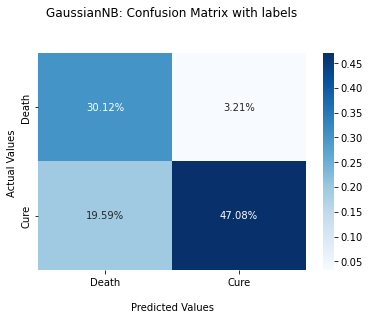

None

----------------------------------------
Bad Predictions: 200854 over 881031--> 22.80%


,Pred_Evolution,Evolution,Age range,Age,Gender,Education Level,Pregnancy,sum_comorb,sum_sym,Fever,Respiratory Difficulty,Cough,Coryza,Sore throat,Diarrhoea,CEPHALGIA,ComorbidityLung,ComorbidityCardio,Renal comorbidity,comorbidity diabetes,Comorbidity Smoking,comorbidity obesity,was hospitalized,International trip,professional health,has a disability,Homeless
0,Death,Cure,1.358003,1.361740,1,0.352592,-0.079411,2,4,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,No,No,No,No,Unknown,Unknown,No,No,No
1,Death,Cure,1.912779,1.704290,1,-0.506148,-0.079411,0,3,Yes,No,Yes,No,No,Yes,No,No,No,No,No,No,No,Unknown,Unknown,No,No,No
2,Death,Cure,-1.970653,-1.778306,0,-1.078641,-0.079411,0,2,No,No,Yes,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No
3,Death,Cure,-0.306325,-0.122645,1,1.211332,-0.079411,0,2,No,No,Yes,Yes,No,No,No,No,No,No,No,No,No,Unknown,Unknown,No,No,No
4,Death,Cure,-0.306325,-0.122645,1,1.211332,-0.079411,0,2,No,No,Yes,Yes,No,No,No,No,No,No,No,No,No,Unknown,Unknown,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881016,Cure,Death,3.022331,2.871696,1,-1.078641,-0.079411,0,1,No,No,Yes,No,No,No,No,No,No,No,No,No,No,Unknown,Unknown,No,No,No
881021,Cure,Death,2.084782,1.960080,0,-1.078641,-0.079411,1,1,No,Yes,No,No,No,No,No,No,Yes,No,No,No,No,Unknown,No,No,No,No
881024,Cure,Death,1.401847,1.626203,1,-1.078641,-0.079411,0,4,Yes,Yes,Yes,No,No,Yes,No,No,No,No,No,No,No,Unknown,Unknown,No,No,No
881027,Cure,Death,1.358003,1.211857,1,0.925085,-0.079411,0,2,No,Yes,Yes,No,No,No,No,No,No,No,No,No,No,No,Unknown,No,No,No


In [36]:
print("10-Fold-CrossValidation Results")
display(result_dict['GaussianNB'][0])
print("-"*40)

print("Aggregated values")
display(show_aggr(result_dict, 'GaussianNB'))
print("-"*40)

print("Confusion Matrix")
display(plot_cm(result_dict['GaussianNB'][2],"GaussianNB"))
print("-"*40)

n_bad_pred_nb = display_bad_predictions(result_dict['GaussianNB'][1]).shape[0]
print("Bad Predictions: " + str(n_bad_pred_nb) + " over " + str(X.shape[0]) + "--> " + "{:.2f}%".format(100*n_bad_pred_nb/X.shape[0]))
display_bad_predictions(result_dict['GaussianNB'][1])

### Decision tree Classifier

10-Fold-CrossValidation Results


,fit_time,score_time,test_r2,train_r2,test_mae,train_mae,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_kappa,train_kappa,test_roc_auc,train_roc_auc,test_pr_auc,train_pr_auc
K1,4.668666,0.100122,0.507219,0.993195,-0.109507,-0.001512,0.890493,0.998488,0.862059,0.998578,0.994943,0.999154,0.923747,0.998866,0.733033,0.996597,0.840890,0.999992,0.862990,0.999996
K2,4.797246,0.098548,0.942436,0.982112,-0.012792,-0.003975,0.987208,0.996025,0.996775,0.996810,0.983996,0.997229,0.990344,0.997019,0.971401,0.991054,0.992206,0.999943,0.994248,0.999969
K3,4.814008,0.097441,0.934008,0.981942,-0.014665,-0.004013,0.985335,0.995987,0.996131,0.996690,0.981817,0.997293,0.988922,0.996991,0.967240,0.990968,0.990443,0.999943,0.992854,0.999969
K4,4.773228,0.097128,0.934059,0.982174,-0.014653,-0.003961,0.985347,0.996039,0.995908,0.996679,0.982055,0.997382,0.988933,0.997030,0.967257,0.991084,0.990556,0.999943,0.993012,0.999969
K5,4.823816,0.096606,0.936563,0.981908,-0.014097,-0.004021,0.985903,0.995979,0.996117,0.996569,0.982685,0.997403,0.989355,0.996986,0.968494,0.990950,0.990764,0.999942,0.993113,0.999969
K6,4.843334,0.101816,0.938811,0.981834,-0.013598,-0.004037,0.986402,0.995963,0.996565,0.996628,0.982991,0.997319,0.989732,0.996973,0.969612,0.990914,0.991028,0.999941,0.993359,0.999968
K7,4.872600,0.096636,0.942284,0.981964,-0.012826,-0.004008,0.987174,0.995992,0.996364,0.996603,0.984353,0.997388,0.990322,0.996995,0.971315,0.990979,0.991919,0.999942,0.994056,0.999968
K8,4.990692,0.097806,0.940752,0.981788,-0.013166,-0.004047,0.986834,0.995953,0.996276,0.996547,0.983928,0.997386,0.990064,0.996966,0.970558,0.990890,0.991411,0.999940,0.993635,0.999968
K9,4.866493,0.095266,0.919606,0.981822,-0.017865,-0.004039,0.982135,0.995961,0.996215,0.996562,0.976913,0.997382,0.986470,0.996972,0.960189,0.990907,0.987954,0.999940,0.991319,0.999968
K10,4.495614,0.096774,0.726946,0.981947,-0.060679,-0.004012,0.939321,0.995988,0.996153,0.996586,0.912505,0.997399,0.952496,0.996992,0.868974,0.990970,0.955996,0.999940,0.970269,0.999968


----------------------------------------
Aggregated values


,fit_time,score_time,test_r2,train_r2,test_mae,train_mae,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_kappa,train_kappa,test_roc_auc,train_roc_auc,test_pr_auc,train_pr_auc
mean,4.794570,0.097814,0.872268,0.983069,-0.028385,-0.003763,0.971615,0.996237,0.982856,0.996825,0.976619,0.997533,0.979039,0.997179,0.934807,0.991531,0.972317,0.999947,0.977886,0.999971
std,0.132927,0.001912,0.144271,0.003560,0.032060,0.000791,0.032060,0.000791,0.042444,0.000621,0.022969,0.000572,0.022632,0.000593,0.077526,0.001781,0.047469,0.000016,0.041016,0.000009
min,4.495614,0.095266,0.507219,0.981788,-0.109507,-0.004047,0.890493,0.995953,0.862059,0.996547,0.912505,0.997229,0.923747,0.996966,0.733033,0.990890,0.840890,0.999940,0.862990,0.999968
max,4.990692,0.101816,0.942436,0.993195,-0.012792,-0.001512,0.987208,0.998488,0.996775,0.998578,0.994943,0.999154,0.990344,0.998866,0.971401,0.996597,0.992206,0.999992,0.994248,0.999996


----------------------------------------
Confusion Matrix


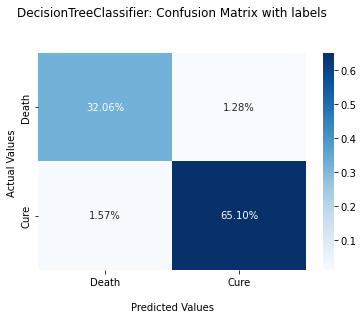

None

----------------------------------------
Bad Predictions: 25049 over 881031--> 2.84%


,Pred_Evolution,Evolution,Age range,Age,Gender,Education Level,Pregnancy,sum_comorb,sum_sym,Fever,Respiratory Difficulty,Cough,Coryza,Sore throat,Diarrhoea,CEPHALGIA,ComorbidityLung,ComorbidityCardio,Renal comorbidity,comorbidity diabetes,Comorbidity Smoking,comorbidity obesity,was hospitalized,International trip,professional health,has a disability,Homeless
5,Death,Cure,-2.525429,-2.235039,0,-1.078641,-0.079411,0,1,No,No,Yes,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No
11,Cure,Death,0.803227,0.676639,1,0.925085,-0.079411,0,0,No,No,No,No,No,No,No,No,No,No,No,No,No,Unknown,Unknown,No,No,No
38,Cure,Death,0.803227,1.076281,1,0.925085,-0.079411,0,1,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No
43,Cure,Death,-2.525429,-2.063764,0,-1.078641,-0.079411,0,1,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
52,Cure,Death,1.912779,1.875566,0,-0.792395,-0.079411,1,1,Yes,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880002,Cure,Death,0.803227,0.962098,0,-1.078641,-0.079411,0,3,Yes,No,Yes,No,No,No,Yes,No,No,No,No,No,No,Unknown,Unknown,No,No,No
880307,Cure,Death,1.358003,1.533015,1,-1.078641,-0.079411,0,0,No,No,No,No,No,No,No,No,No,No,No,No,No,Unknown,Unknown,No,No,No
880622,Cure,Death,0.248451,0.417222,1,-1.078641,-0.079411,0,2,Yes,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
880633,Cure,Death,1.358003,1.375762,0,-1.078641,-0.079411,2,1,No,Yes,No,No,No,No,No,No,Yes,Yes,No,No,No,No,Unknown,No,No,No


In [37]:
print("10-Fold-CrossValidation Results")
display(result_dict['DecisionTreeClassifier'][0])
print("-"*40)

print("Aggregated values")
display(show_aggr(result_dict, 'DecisionTreeClassifier'))
print("-"*40)

print("Confusion Matrix")
display(plot_cm(result_dict['DecisionTreeClassifier'][2],'DecisionTreeClassifier'))
print("-"*40)

n_bad_pred_dtc = display_bad_predictions(result_dict['DecisionTreeClassifier'][1]).shape[0]
print("Bad Predictions: " + str(n_bad_pred_dtc) + " over " + str(X.shape[0]) + "--> " + "{:.2f}%".format(100*n_bad_pred_dtc/X.shape[0]))
display_bad_predictions(result_dict['DecisionTreeClassifier'][1])

### RandomForestClassifier

10-Fold-CrossValidation Results


,fit_time,score_time,test_r2,train_r2,test_mae,train_mae,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_kappa,train_kappa,test_roc_auc,train_roc_auc,test_pr_auc,train_pr_auc
K1,24.404291,0.929742,0.733741,0.993178,-0.059169,-0.001516,0.940831,0.998484,0.925928,0.998544,0.990483,0.999183,0.957118,0.998863,0.862062,0.996588,0.982334,0.999966,0.985192,0.999983
K2,28.389063,1.049416,0.941261,0.982112,-0.013053,-0.003975,0.986947,0.996025,0.994521,0.996043,0.985852,0.998002,0.990168,0.997022,0.970758,0.991047,0.998598,0.999842,0.999286,0.999919
K3,27.950255,1.081947,0.934621,0.981942,-0.014528,-0.004013,0.985472,0.995987,0.994067,0.995964,0.984081,0.998025,0.989049,0.996993,0.967474,0.990961,0.998622,0.999841,0.999276,0.999919
K4,27.470226,1.026185,0.937277,0.982163,-0.013938,-0.003964,0.986062,0.996036,0.993445,0.995940,0.985597,0.998123,0.989505,0.997030,0.968762,0.991072,0.998484,0.999838,0.999209,0.999917
K5,25.596200,0.985807,0.941364,0.981879,-0.013030,-0.004027,0.986970,0.995973,0.994317,0.995782,0.986090,0.998188,0.990187,0.996984,0.970803,0.990929,0.998752,0.999839,0.999376,0.999918
K6,26.984043,1.070745,0.941364,0.981828,-0.013030,-0.004038,0.986970,0.995962,0.993403,0.995786,0.987009,0.998167,0.990196,0.996975,0.970776,0.990903,0.998770,0.999839,0.999347,0.999918
K7,27.967554,1.054797,0.945451,0.981964,-0.012122,-0.004008,0.987878,0.995992,0.993564,0.995838,0.988218,0.998159,0.990884,0.996998,0.972798,0.990972,0.998845,0.999835,0.999386,0.999916
K8,25.275238,0.943607,0.943918,0.981777,-0.012463,-0.004050,0.987537,0.995950,0.993611,0.995767,0.987656,0.998169,0.990625,0.996966,0.972043,0.990878,0.998811,0.999835,0.999391,0.999916
K9,25.263072,0.965864,0.927931,0.981817,-0.016015,-0.004041,0.983985,0.995959,0.993781,0.995820,0.982123,0.998129,0.987918,0.996973,0.964176,0.990898,0.998426,0.999835,0.999195,0.999916
K10,26.386275,1.053919,0.894476,0.981930,-0.023450,-0.004015,0.976550,0.995985,0.993727,0.995885,0.970954,0.998101,0.982209,0.996992,0.947836,0.990955,0.997475,0.999835,0.998657,0.999916


----------------------------------------
Aggregated values


,fit_time,score_time,test_r2,train_r2,test_mae,train_mae,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_kappa,train_kappa,test_roc_auc,train_roc_auc,test_pr_auc,train_pr_auc
mean,26.568622,1.016203,0.914141,0.983059,-0.019080,-0.003765,0.980920,0.996235,0.987036,0.996137,0.984806,0.998225,0.985786,0.997180,0.956749,0.991520,0.996912,0.999851,0.997832,0.999924
std,1.382666,0.055393,0.065116,0.003558,0.014470,0.000791,0.014470,0.000791,0.021474,0.000851,0.005373,0.000342,0.010387,0.000592,0.034061,0.001782,0.005137,0.000041,0.004446,0.000021
min,24.404291,0.929742,0.733741,0.981777,-0.059169,-0.004050,0.940831,0.995950,0.925928,0.995767,0.970954,0.998002,0.957118,0.996966,0.862062,0.990878,0.982334,0.999835,0.985192,0.999916
max,28.389063,1.081947,0.945451,0.993178,-0.012122,-0.001516,0.987878,0.998484,0.994521,0.998544,0.990483,0.999183,0.990884,0.998863,0.972798,0.996588,0.998845,0.999966,0.999391,0.999983


----------------------------------------
Confusion Matrix


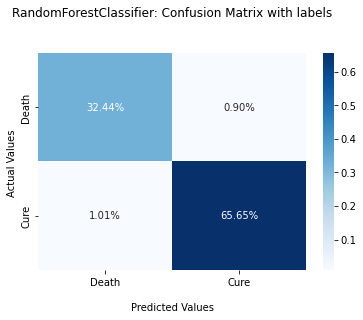

None

----------------------------------------
Bad Predictions: 16844 over 881031--> 1.91%


,Pred_Evolution,Evolution,Age range,Age,Gender,Education Level,Pregnancy,sum_comorb,sum_sym,Fever,Respiratory Difficulty,Cough,Coryza,Sore throat,Diarrhoea,CEPHALGIA,ComorbidityLung,ComorbidityCardio,Renal comorbidity,comorbidity diabetes,Comorbidity Smoking,comorbidity obesity,was hospitalized,International trip,professional health,has a disability,Homeless
11,Cure,Death,0.803227,0.676639,1,0.925085,-0.079411,0,0,No,No,No,No,No,No,No,No,No,No,No,No,No,Unknown,Unknown,No,No,No
38,Cure,Death,0.803227,1.076281,1,0.925085,-0.079411,0,1,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No
43,Cure,Death,-2.525429,-2.063764,0,-1.078641,-0.079411,0,1,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
135,Cure,Death,0.803227,1.076281,1,-1.078641,4.422439,3,2,No,Yes,Yes,No,No,No,No,Yes,Yes,No,No,No,Yes,Unknown,Unknown,No,No,No
169,Cure,Death,-0.861101,-0.864838,1,-0.792395,-0.079411,0,0,No,No,No,No,No,No,No,No,No,No,No,No,No,Unknown,Unknown,No,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880668,Cure,Death,1.912779,1.989749,1,-1.078641,-0.079411,0,0,No,No,No,No,No,No,No,No,No,No,No,No,No,Unknown,Unknown,No,No,No
880692,Cure,Death,1.358003,1.362190,0,-0.506148,-0.079411,0,0,No,No,No,No,No,No,No,No,No,No,No,No,No,Unknown,Unknown,No,No,No
880735,Cure,Death,1.358003,1.368004,1,0.360444,-0.079411,0,2,Yes,No,Yes,No,No,No,No,No,No,No,No,No,No,Unknown,Unknown,No,No,No
880761,Cure,Death,1.358003,1.304414,1,-1.078641,-0.079411,0,2,Yes,No,Yes,No,No,No,No,No,No,No,No,No,No,Unknown,Unknown,No,No,No


In [38]:
print("10-Fold-CrossValidation Results")
display(result_dict['RandomForestClassifier'][0])
print("-"*40)

print("Aggregated values")
display(show_aggr(result_dict, 'RandomForestClassifier'))
print("-"*40)

print("Confusion Matrix")
display(plot_cm(result_dict['RandomForestClassifier'][2],'RandomForestClassifier'))
print("-"*40)

n_bad_pred_rfc = display_bad_predictions(result_dict['RandomForestClassifier'][1]).shape[0]
print("Bad Predictions: " + str(n_bad_pred_rfc) + " over " + str(X.shape[0]) + "--> " + "{:.2f}%".format(100*n_bad_pred_rfc/X.shape[0]))
display_bad_predictions(result_dict['RandomForestClassifier'][1])

## Plot Comulative Data

In [39]:
total_values = get_total_values(result_dict,"mean")

In [40]:
print("All Metrics")
display(show_total_values(total_values, "all"))
print("-"*40)

print("Test-set Metrics")
display(show_total_values(total_values, "test"))
print("-"*40)

print("Train-set Metrics")
display(show_total_values(total_values, "train"))

All Metrics


,fit_time,score_time,test_r2,train_r2,test_mae,train_mae,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_kappa,train_kappa,test_roc_auc,train_roc_auc,test_pr_auc,train_pr_auc
LogisticRegression,206.603830,0.143427,0.659509,0.701185,-0.075665,-0.066403,0.924335,0.933597,0.936159,0.937405,0.951535,0.964822,0.943267,0.950916,0.829372,0.848375,0.971489,0.980239,0.985561,0.989334
LinearDiscriminantAnalysis,4.912799,0.141828,0.610470,0.648422,-0.086562,-0.078129,0.913438,0.921871,0.909858,0.911054,0.965925,0.978321,0.936612,0.943490,0.800050,0.817472,0.970684,0.977638,0.985117,0.988151
GaussianNB,0.457834,0.137112,-0.025890,0.032540,-0.227976,-0.214991,0.772024,0.785009,0.940313,0.944649,0.706200,0.725796,0.790331,0.801773,0.552978,0.577256,0.906965,0.922134,0.945905,0.953500
DecisionTreeClassifier,4.794570,0.097814,0.872268,0.983069,-0.028385,-0.003763,0.971615,0.996237,0.982856,0.996825,0.976619,0.997533,0.979039,0.997179,0.934807,0.991531,0.972317,0.999947,0.977886,0.999971
RandomForestClassifier,26.568622,1.016203,0.914141,0.983059,-0.019080,-0.003765,0.980920,0.996235,0.987036,0.996137,0.984806,0.998225,0.985786,0.997180,0.956749,0.991520,0.996912,0.999851,0.997832,0.999924


----------------------------------------
Test-set Metrics


,fit_time,score_time,test_r2,test_mae,test_accuracy,test_precision,test_recall,test_f1,test_kappa,test_roc_auc,test_pr_auc
LogisticRegression,206.603830,0.143427,0.659509,-0.075665,0.924335,0.936159,0.951535,0.943267,0.829372,0.971489,0.985561
LinearDiscriminantAnalysis,4.912799,0.141828,0.610470,-0.086562,0.913438,0.909858,0.965925,0.936612,0.800050,0.970684,0.985117
GaussianNB,0.457834,0.137112,-0.025890,-0.227976,0.772024,0.940313,0.706200,0.790331,0.552978,0.906965,0.945905
DecisionTreeClassifier,4.794570,0.097814,0.872268,-0.028385,0.971615,0.982856,0.976619,0.979039,0.934807,0.972317,0.977886
RandomForestClassifier,26.568622,1.016203,0.914141,-0.019080,0.980920,0.987036,0.984806,0.985786,0.956749,0.996912,0.997832


----------------------------------------
Train-set Metrics


,fit_time,score_time,train_r2,train_mae,train_accuracy,train_precision,train_recall,train_f1,train_kappa,train_roc_auc,train_pr_auc
LogisticRegression,206.603830,0.143427,0.701185,-0.066403,0.933597,0.937405,0.964822,0.950916,0.848375,0.980239,0.989334
LinearDiscriminantAnalysis,4.912799,0.141828,0.648422,-0.078129,0.921871,0.911054,0.978321,0.943490,0.817472,0.977638,0.988151
GaussianNB,0.457834,0.137112,0.032540,-0.214991,0.785009,0.944649,0.725796,0.801773,0.577256,0.922134,0.953500
DecisionTreeClassifier,4.794570,0.097814,0.983069,-0.003763,0.996237,0.996825,0.997533,0.997179,0.991531,0.999947,0.999971
RandomForestClassifier,26.568622,1.016203,0.983059,-0.003765,0.996235,0.996137,0.998225,0.997180,0.991520,0.999851,0.999924


## Model selection: RandomForestClassifier

From the analysis above, we can clearly see that the best models for our purpose are the RandomForestClassifier and the DecisionTreeClassifier.

Since the second model is nothing more than a combination of 50 DecisionTrees, considering an execution time per single cycle of 138 seconds (2.3 minutes), we will examine, at the moment, only these two.

For our purpose, the choice falls on the RandomForest model, given the relatively short execution times and accuracy in the predictions.

Now, let's test our model

In [41]:
X_id_sel = df_closed_enc.drop('Evolution',axis=1)
y_id_sel = df_closed_enc.Evolution
print("X_id_sel shape:", X_id_sel.shape, "|", "y_id_sel shape:", y_id_sel.shape)

X_id_sel shape: (600242, 61) | y_id_sel shape: (600242,)


In [42]:
sm = SMOTE(sampling_strategy=0.5)
X_sm, y_sm = sm.fit_resample(X_id_sel, y_id_sel)
print('Resampled dataset shape %s' % Counter(y_sm))
print("X_sel shape:", X_sm.shape, "|", "y_sel shape:", y_sm.shape)

Resampled dataset shape Counter({1: 587354, 0: 293677})
X_sel shape: (881031, 61) | y_sel shape: (881031,)


In [43]:
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sm, y_sm, test_size=0.30)
print("X_train shape:", X_train_sel.shape, "|", "y_train shape:", y_train_sel.shape)
print("X_test shape:", X_test_sel.shape, "|", "y_test shape:", y_test_sel.shape)

X_train shape: (616721, 61) | y_train shape: (616721,)
X_test shape: (264310, 61) | y_test shape: (264310,)


In [44]:
model_selected = RandomForestClassifier(n_estimators=100, n_jobs=4)
model_selected.fit(X_train_sel,y_train_sel)

RandomForestClassifier(n_jobs=4)

In [45]:
predicted_rf = model_selected.predict(X_test_sel)

In [46]:
proba_rf = model_selected.predict_proba(X_test_sel)[:, 1]

In [47]:
score_selected = {
        "r2": r2_score(y_test_sel, predicted_rf),
        "mae": mean_absolute_error(y_test_sel, predicted_rf),
        "accuracy": accuracy_score(y_test_sel, predicted_rf),
        "precision": precision_score(y_test_sel, predicted_rf),
        "recall": recall_score(y_test_sel, predicted_rf),
        "f1": f1_score(y_test_sel, predicted_rf),
        "kappa": cohen_kappa_score(y_test_sel, predicted_rf),
        "roc_auc": roc_auc_score(y_test_sel, proba_rf),
        "pr_auc": average_precision_score(y_test_sel, proba_rf)
    }
cm_selected = confusion_matrix(y_test_sel, predicted_rf)

In [48]:
predict_df = decoding_dataset(merge_predict_test(X_test_sel,y_test_sel,predicted_rf))
n_bad_pred_model = display_bad_predictions(predict_df).shape[0]

SCORING
----------------------------------------
R2 Error:  0.911
Mean Absolute Error:  0.020


Accuracy:  0.980
Precision:  0.986
Recall:  0.984
F1-Score:  0.985
Cohen's Kappa Score:  0.955


RoC AUC Score:  0.996
Precision-Recall AUC Score:  0.997
----------------------------------------
Bad Predictions: 5235 over 264310--> 1.98%


,Pred_Evolution,Evolution,Age range,Age,Gender,Education Level,Pregnancy,sum_comorb,sum_sym,Fever,Respiratory Difficulty,Cough,Coryza,Sore throat,Diarrhoea,CEPHALGIA,ComorbidityLung,ComorbidityCardio,Renal comorbidity,comorbidity diabetes,Comorbidity Smoking,comorbidity obesity,was hospitalized,International trip,professional health,has a disability,Homeless
77,Death,Cure,70-79,74,F,Unknown,No,1,1,No,No,Yes,No,No,No,No,No,Yes,No,No,No,No,Yes,Unknown,No,No,No
115,Death,Cure,50-59,53,M,Incomplete 5th to 8th grade of elementary school,No,0,2,No,Yes,No,No,No,No,Yes,No,No,No,No,No,No,Yes,No,No,No,No
160,Cure,Death,50-59,57,F,Unknown,No,0,4,Yes,No,Yes,No,No,Yes,Yes,No,No,No,No,No,No,Unknown,Unknown,No,No,No
205,Death,Cure,60-69,65,F,Incomplete 1st to 4th grade of elementary school,No,2,2,No,Yes,No,No,No,No,Yes,No,Yes,No,Yes,No,No,No,No,No,No,No
284,Cure,Death,70-79,73,F,Unknown,No,0,3,Yes,No,Yes,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264040,Death,Cure,60-69,61,F,Complete elementary school,No,1,3,Yes,Yes,No,No,No,No,Yes,No,Yes,No,No,No,No,No,No,No,No,No
264138,Death,Cure,60-69,64,F,Unknown,No,1,2,Yes,Yes,No,No,No,No,No,No,Yes,No,No,No,No,Unknown,Unknown,No,No,No
264168,Cure,Death,60-69,62,M,Complete higher education,No,2,4,Yes,No,No,Yes,No,Yes,Yes,No,Yes,No,Yes,No,No,No,No,No,No,No
264253,Death,Cure,50-59,56,F,Complete high school,No,0,4,Yes,Yes,Yes,No,No,No,Yes,No,No,No,No,No,No,Yes,Unknown,No,No,No


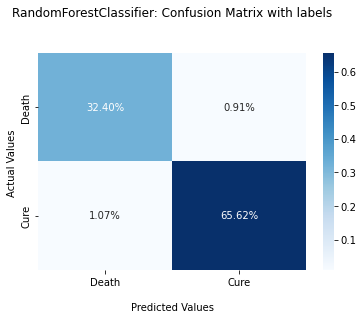

In [49]:
print("SCORING")
print("-"*40)

print("R2 Error: ", "{:.3f}".format(score_selected["r2"]))
print("Mean Absolute Error: ", "{:.3f}".format(score_selected["mae"]))
print("\n")
print("Accuracy: ", "{:.3f}".format(score_selected['accuracy']))
print("Precision: ", "{:.3f}".format(score_selected['precision']))
print("Recall: ", "{:.3f}".format(score_selected['recall']))
print("F1-Score: ", "{:.3f}".format(score_selected['f1']))
print("Cohen's Kappa Score: ", "{:.3f}".format(score_selected['kappa']))
print("\n")
print("RoC AUC Score: ", "{:.3f}".format(score_selected['roc_auc']))
print("Precision-Recall AUC Score: ", "{:.3f}".format(score_selected['pr_auc']))

print("-"*40)

print("Bad Predictions: " + str(n_bad_pred_model) + " over " + str(X_test_sel.shape[0]) + "--> " +
      "{:.2f}%".format(100*n_bad_pred_model/X_test_sel.shape[0]))
display(display_bad_predictions(predict_df))

plot_cm(cm_selected, "RandomForestClassifier")

## Save Model

In [50]:
dump(model_selected, 'randomforest_braz_data.joblib')

['randomforest_braz_data.joblib']

## Analysis on Bad prediction

In [51]:
bad_predictions = display_bad_predictions(predict_df)

In [52]:
bad_predictions.loc[(bad_predictions["Evolution"] == "Cure")
                    & ((bad_predictions["sum_comorb"] < 2) | (bad_predictions["sum_sym"] < 2))
                    & (bad_predictions["professional health"] == "Yes")]

,Pred_Evolution,Evolution,Age range,Age,Gender,Education Level,Pregnancy,sum_comorb,sum_sym,Fever,Respiratory Difficulty,Cough,Coryza,Sore throat,Diarrhoea,CEPHALGIA,ComorbidityLung,ComorbidityCardio,Renal comorbidity,comorbidity diabetes,Comorbidity Smoking,comorbidity obesity,was hospitalized,International trip,professional health,has a disability,Homeless
22032,Death,Cure,40-49,48,M,Incomplete higher education,No,1,1,Yes,No,No,No,No,No,No,No,Yes,No,No,No,No,Yes,Unknown,Yes,No,No
55345,Death,Cure,60-69,62,F,Incomplete 5th to 8th grade of elementary school,No,1,3,Yes,Yes,Yes,No,No,No,No,No,Yes,No,No,No,No,Yes,No,Yes,No,No
100874,Death,Cure,80-89,89,F,Incomplete high school,No,1,3,No,Yes,No,Yes,Yes,No,No,No,Yes,No,No,No,No,Yes,No,Yes,No,No
134075,Death,Cure,60-69,69,M,Complete higher education,No,1,3,Yes,Yes,No,No,No,Yes,No,No,Yes,No,No,No,No,Yes,No,Yes,No,No
134219,Death,Cure,50-59,58,M,Complete higher education,No,0,4,Yes,No,Yes,Yes,No,No,Yes,No,No,No,No,No,No,Yes,No,Yes,No,No
137941,Death,Cure,60-69,65,M,Complete higher education,No,1,2,Yes,Yes,No,No,No,No,No,No,No,Yes,No,No,No,Yes,No,Yes,No,No
166444,Death,Cure,70-79,70,M,Unknown,No,1,3,Yes,Yes,Yes,No,No,No,No,No,Yes,No,No,No,No,No,No,Yes,No,No
198602,Death,Cure,90-100,91,F,Illliterate,No,1,2,No,Yes,No,No,No,Yes,No,No,Yes,No,No,No,No,No,No,Yes,No,No
211079,Death,Cure,70-79,79,F,Unknown,No,0,4,Yes,Yes,Yes,No,No,No,Yes,No,No,No,No,No,No,Unknown,Unknown,Yes,No,No
219359,Death,Cure,60-69,62,F,Unknown,No,0,2,No,Yes,Yes,No,No,No,No,No,No,No,No,No,No,Yes,No,Yes,No,No
